# "Food Vision" en Food101 de Kaggle

* This is gonna be my first project of deep learning from the knowlege of Udemy - TensorFlow Developer Certificate Bootcamp
* For this i going to use the know dataset of Kaggle Food101 from this link: https://www.kaggle.com/datasets/dansbecker/food-101
* Also i imported a python file call helper_function.py that have a lot of useful function to plot and view our data

## Import all the modules and libraries

In [1]:
from helper_functions import *
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
import tensorflow_datasets as tfds
import zipfile
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

C:\Users\Tomy\anaconda3.1\envs\deeplearning-GPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check GPU working

In [5]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 2070 SUPER (UUID: GPU-572fe43f-9874-821c-8a5f-e3f1cd3905b6)


For this project i going to use the mixed precision technique, that i'm allow due to my GPU capability of 7.5 (Nvidia Geforce rtx 2070 Super)

## Datasets of Food101

### TensorFLow Datasets (TFDS) Download 

In [6]:
# List all the available datasets
datasets_list = tfds.list_builders() #get all the availble datasets on tfds
print("food101" in datasets_list) # Finds if food101 is on the dataset list created

True


In [7]:

# Load in the data 
(train_data, test_data), ds_info = tfds.load(name='food101', 
                                            split= ["train", "validation"],
                                            shuffle_files = True,
                                            as_supervised= True, #Data gets returned in tuple format (data, label)
                                            with_info= True)

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

### Data Visualization

* Class Names
* Shape of our inputs data
* Data type
* Do the labels match up with class names

In [9]:
# Get the class names
class_names = ds_info.features['label'].names
class_names[0:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
# Take one sample of the train data
train_one_sample = train_data.take(1)
for image, label in train_one_sample:
    print(image.shape)
    print(class_names[label])

(512, 288, 3)
steak


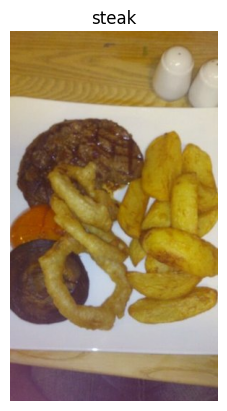

In [11]:
# Visualize the image
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

### Preprocessing Data

**Preprocessing Functions:**
- Neural Network perform best when (batched, augmented, normalize)
- Map the data with functions
- I need to ensure that the data comes in this forms in order to the model perfoms better
    
**What do i know about the data:**
- `uint8` dtype
- Comprised of all different size tensor (different sizes of images)
- Not scaled (pixels between 0 - 255)

**How our model should be:**
- Data in `float32` dtype (or mixed precision float16)
- For batches, TensorFlow likes all of the tensors within a batch to be of the same size
- Scaled (values between 0 and 1) generally perform better

In [12]:
# Make a function to preprocces images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from uint8 to float32 and reshape the image to [img_shape, img_shape, colour_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) #reshape the target image
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [13]:
#Preprocess a single image
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2][0][0]}, \nShape: {image.shape}, Datatype: {image.dtype}")
print("\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2][0][0]}, \nShape: {preprocessed_img.shape}, Datatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [148 103  36], 
Shape: (512, 288, 3), Datatype: <dtype: 'uint8'>


Image after preprocessing:
 [147.30612 102.30612  35.30612], 
Shape: (224, 224, 3), Datatype: <dtype: 'float32'>


### Batch and Prepare datasets

Batches allows the input data pipeline runs faster

In [14]:
# Map preprocessing function to traning and parallelize
train_data = train_data.map(map_func= preprocess_img, #map use a function in our trianing data in our case our funct of preprocesses images
                            num_parallel_calls=tf.data.AUTOTUNE) #with autotune we can use all the CPUs to parallelize the preprocess

#Turn ir into batches and prefetch it (loads faster)
train_data = train_data.batch(32).prefetch(tf.data.AUTOTUNE)

#Testing data
test_data = test_data.map(map_func = preprocess_img, #map use a function in our trianing data in our case our funct of preprocesses images
                            num_parallel_calls = tf.data.AUTOTUNE) #with autotune we can use all the CPUs to parallelize the preprocess

#Turn ir into batches and prefetch it (loads faster)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE) #prefetch it's like being compute while 1 batch it's being used but preprares another batch at the same time for a GPU, makes our datasets more efficent

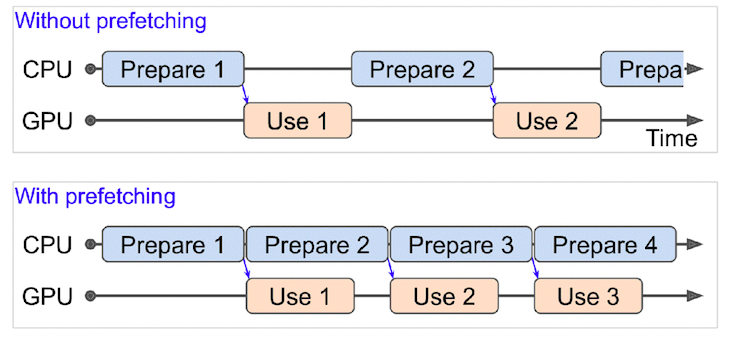

In [15]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Creating modelling callbacks


- TensorBoard callback: to log the training results (later visualization)
- ModelCheckpoint callback: to save our model's progress after feature extraction
  

In [16]:
# Create ModelCheckpoint callback to save the model progress
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, # pass the path to store
                                                     monitor = "val_accuracy", # What metric we want to monitor in order to save our model
                                                     save_best_only = True, #Only saves the best epoch
                                                     save_weights_only=True, # The checkpoint only have weights
                                                     verbose = 0) # Dont print anything in the console output
                                                     


### Setup mixed precision traning

In [22]:
# Turn ON miexes precision training
policy = tf.keras.mixed_precision.Policy('float32') 
tf.keras.mixed_precision.set_global_policy(policy)

### Model Build with feature extractor

In [23]:
# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Create funtional model
inputs = layers.Input(shape = input_shape, name = 'input_layer') # Note: EfficentNetB0 models hace rescaling built-in
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype = tf.float32, name = "softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer = tf.keras.optimizers.Adam(),
             metrics = ["accuracy"])


In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [25]:
# Check the dtype_policy of our layers
for layers in model.layers:
    print(layers.name, layers.dtype, layers.dtype_policy)

input_layer float32 <Policy "float32">
efficientnetb0 float32 <Policy "float32">
global_average_pooling2d float32 <Policy "float32">
dense float32 <Policy "float32">
softmax_float32 float32 <Policy "float32">


### Fit the feature extractor model

In [26]:
history_0 = model.fit(train_data,
                     epochs = 3,
                     steps_per_epoch = len(train_data),
                     validation_data= test_data,
                     validation_steps= int(0.15 * len(test_data)),
                     callbacks = [create_tensorboard_callback("training_logs", "efficentnet_101classes"),
                                          model_checkpoint])

Saving TensorBoard log files to: training_logs\efficentnet_101classes\20240218-134153
Epoch 1/3
2368/2368 [==============================] - 125s 47ms/step - loss: 1.7156 - accuracy: 0.5809 - val_loss: 1.1222 - val_accuracy: 0.6973
Epoch 2/3
2368/2368 [==============================] - 110s 46ms/step - loss: 1.1989 - accuracy: 0.6883 - val_loss: 1.0123 - val_accuracy: 0.7235
Epoch 3/3
2368/2368 [==============================] - 110s 46ms/step - loss: 1.0538 - accuracy: 0.7244 - val_loss: 0.9833 - val_accuracy: 0.7283


In [27]:
# Evaluate our model 

model.evaluate(test_data)

790/790 [==============================] - 37s 46ms/step - loss: 1.0018 - accuracy: 0.7279


[1.0017917156219482, 0.7279207706451416]

**At this point i have a 73% of accuracy in my model so now i need to fine tunning**

## Fine-Tunning

### Save the whole model

In [29]:
# Save model localy
model.save('Model_Food101')

INFO:tensorflow:Assets written to: Model_Food101\assets


INFO:tensorflow:Assets written to: Model_Food101\assets


### Load model

In [30]:
# load the model 
model_saved = tf.keras.models.load_model('Model_Food101')

In [31]:
model_saved.evaluate(test_data)

790/790 [==============================] - 39s 46ms/step - loss: 1.0018 - accuracy: 0.7279


[1.0017911195755005, 0.7279207706451416]

### Callbacks

In [39]:
# Create ModelCheckpoint callback to save the model progress
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, # pass the path to store
                                                     monitor = "val_accuracy", # What metric we want to monitor in order to save our model
                                                     save_best_only = True, #Only saves the best epoch
                                                     save_weights_only=True, # The checkpoint only have weights
                                                     verbose = 0) # Dont print anything in the console output



# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [38]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
for layer in model_saved.layers:
    layer.trainable = True
    print(layer.name, layer.trainable) # print if is trainable or not

input_layer True
efficientnetb0 True
global_average_pooling2d True
dense True
softmax_float32 True


### Fine Tuning

In [41]:


# Compile the model saved
model_saved.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer = tf.keras.optimizers.Adam(0.0001), #In fine tuning typically you want to lower the learning rate 10x
                 metrics = ['accuracy'])

history_finetuning = model_saved.fit(train_data,
                                     epochs = 100,
                                     steps_per_epoch = len(train_data),
                                     validation_data= test_data,
                                     validation_steps= int(0.15 * len(test_data)),
                                     callbacks = [create_tensorboard_callback("training_logs", "efficentnet_101classes_finetuning"),
                                                          model_checkpoint,
                                                          early_stopping,
                                                          reduce_lr])


Saving TensorBoard log files to: training_logs\efficentnet_101classes_finetuning\20240218-141025
Epoch 1/100
2368/2368 [==============================] - 523s 216ms/step - loss: 0.8526 - accuracy: 0.7699 - val_loss: 0.7954 - val_accuracy: 0.7720 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 554s 234ms/step - loss: 0.5215 - accuracy: 0.8560 - val_loss: 0.7682 - val_accuracy: 0.7871 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 571s 241ms/step - loss: 0.2880 - accuracy: 0.9187 - val_loss: 0.8196 - val_accuracy: 0.7956 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1517 - accuracy: 0.9552
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 567s 239ms/step - loss: 0.1517 - accuracy: 0.9552 - val_loss: 0.9726 - val_accuracy: 0.7815 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 552s 233ms/step - 

In [44]:
# Save the model
model_saved.save("model_finetuned_Food101")

INFO:tensorflow:Assets written to: model_finetuned_Food101\assets


INFO:tensorflow:Assets written to: model_finetuned_Food101\assets


In [45]:
model_saved.evaluate(test_data)

790/790 [==============================] - 36s 45ms/step - loss: 1.0096 - accuracy: 0.8031


[1.0095778703689575, 0.803128719329834]

## PLUS: TensorBoard View

In [6]:
# Upload experiment results to TensorBoard (uncomment to run)
%load_ext tensorboard
%tensorboard --logdir training_logs